In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import plot_tree

# Загрузка данных

In [3]:
columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","target",'ne_ponytno']

In [4]:
train = pd.read_csv('../data/KDD/KDDTrain+.txt', names=columns).drop_duplicates()
test = pd.read_csv('../data/KDD/KDDTest+.txt', names=columns)

In [5]:
test_21 = pd.read_csv('../data/KDD/KDDTest-21.txt', names=columns)

In [6]:
print(f'Размер тестовой выборки в файле KDDTest+.txt: {len(test)}\n')
print(f'Размер тестовой выборки в файле KDDTest-21.txt: {len(test_21)}\n')
print(f'Размер общей тестовой выборки: {len(pd.concat([test_21,test],ignore_index=True))}\n')
print(f'Размер общей тестовой выборки после удаления дубликатов: {len(pd.concat([test_21,test],ignore_index=True).drop_duplicates())}\n')

Размер тестовой выборки в файле KDDTest+.txt: 22544

Размер тестовой выборки в файле KDDTest-21.txt: 11850

Размер общей тестовой выборки: 34394

Размер общей тестовой выборки после удаления дубликатов: 22544



In [7]:
df = pd.concat([train,test],ignore_index=True)

In [8]:
df.shape

(148517, 43)

Не понятно, что за столбец

In [9]:
df.ne_ponytno.value_counts()

21    73251
18    23634
20    20682
19    11174
15     5166
17     4242
16     3074
14     1410
12     1215
11     1102
13      970
10      448
7       367
9       300
6       253
8       237
0       189
5       184
3       181
4       180
1       149
2       109
Name: ne_ponytno, dtype: int64

# Задача многоклассовой классификации

## Преобразование типов аномалий в 5 основных классов

In [75]:
train_classes_mapping = '''back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l'''

test_classes_mapping = '''apache2 dos
mailbomb dos
processtable dos
udpstorm dos
mscan probe
saint probe
httptunnel u2r
ps u2r
sqlattack u2r
xterm u2r
sendmail r2l
named r2l
snmpgetattack r2l
snmpguess r2l
xlock r2l
xsnoop r2l
worm r2l'''

In [79]:
classes_mapping = train_classes_mapping+'\n'+test_classes_mapping

In [88]:
# Сохранение в pickle
with open('utils/classes_mapping.pickle','wb') as f:
    pickle.dump(classes_mapping, f)

In [10]:
# Загрузка функции
from utils.common_utils import fraud_classes_mapping

In [11]:
y_tr = fraud_classes_mapping(train.target)
y_test = fraud_classes_mapping(test.target)
y_df = fraud_classes_mapping(df.target)

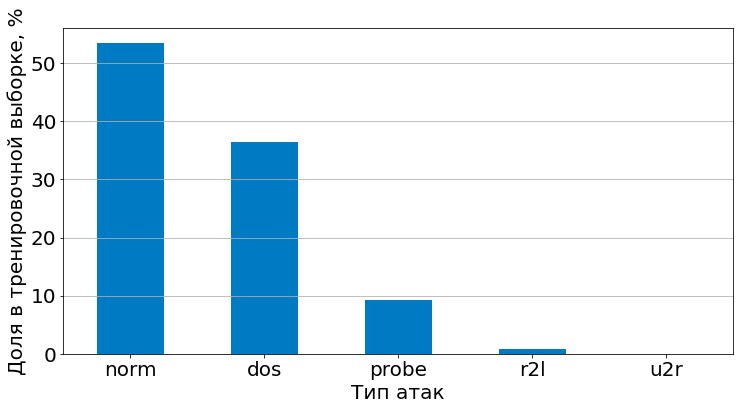

In [12]:
# Построим распределение классов в трейне
matplotlib.rcParams.update({'font.size': 20})
(y_tr.value_counts()/len(y_tr)*100).plot.bar(figsize=(12,6), color='#007AC3', rot=0)
plt.ylabel('Доля в тренировочной выборке, %')
plt.xlabel('Тип атак')
plt.grid(axis='y')
plt.show()

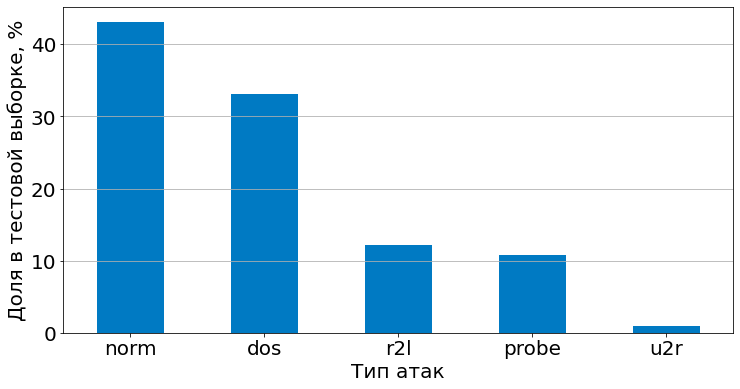

In [13]:
# Построим распределение классов в тесте
matplotlib.rcParams.update({'font.size': 20})
(y_test.value_counts()/len(y_test)*100).plot.bar(figsize=(12,6), color='#007AC3', rot=0)
plt.ylabel('Доля в тестовой выборке, %')
plt.xlabel('Тип атак')
plt.grid(axis='y')
plt.show()

## Обучение модели

In [14]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = LabelEncoder().fit_transform(df[i])

In [15]:
le_y = LabelEncoder()
le_y.fit(y_df)

LabelEncoder()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(df[:len(train)].drop(['target'], axis=1), le_y.transform(y_tr), test_size=0.2, random_state=42, stratify=le_y.transform(y_tr))

In [17]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=1, class_weight={0: 0.33, 1: 0.43, 2: 0.1, 3: 0.12, 4: 0.0089})

In [18]:
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.33, 1: 0.43, 2: 0.1, 3: 0.12,
                                     4: 0.0089},
                       n_jobs=-1, random_state=1)

Валидационная выборка:

In [19]:
print(f'Точность на валидационной выборке: {accuracy_score(rfc.predict(X_val),y_val):.5f}')

Точность на валидационной выборке: 0.99952


Тестовая выборка:

In [20]:
print(f"Точность на тестовой выборке: {accuracy_score(rfc.predict(df[len(train):].drop(['target'], axis=1)), le_y.transform(y_test)):.4f}")


Точность на тестовой выборке: 0.7758


In [21]:
start = datetime.datetime.now()
rfc.predict(df[len(train):].drop('target', axis=1))
end = datetime.datetime.now()
print(f'Время выполнения расчета для {len(y_test)} строк логов (тестовая выборка):\n{end-start}')

Время выполнения расчета для 22544 строк логов (тестовая выборка):
0:00:00.115835


In [22]:
%%timeit
rfc.predict(df[len(train):].drop('target', axis=1))

115 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Визуализируем важность признаков

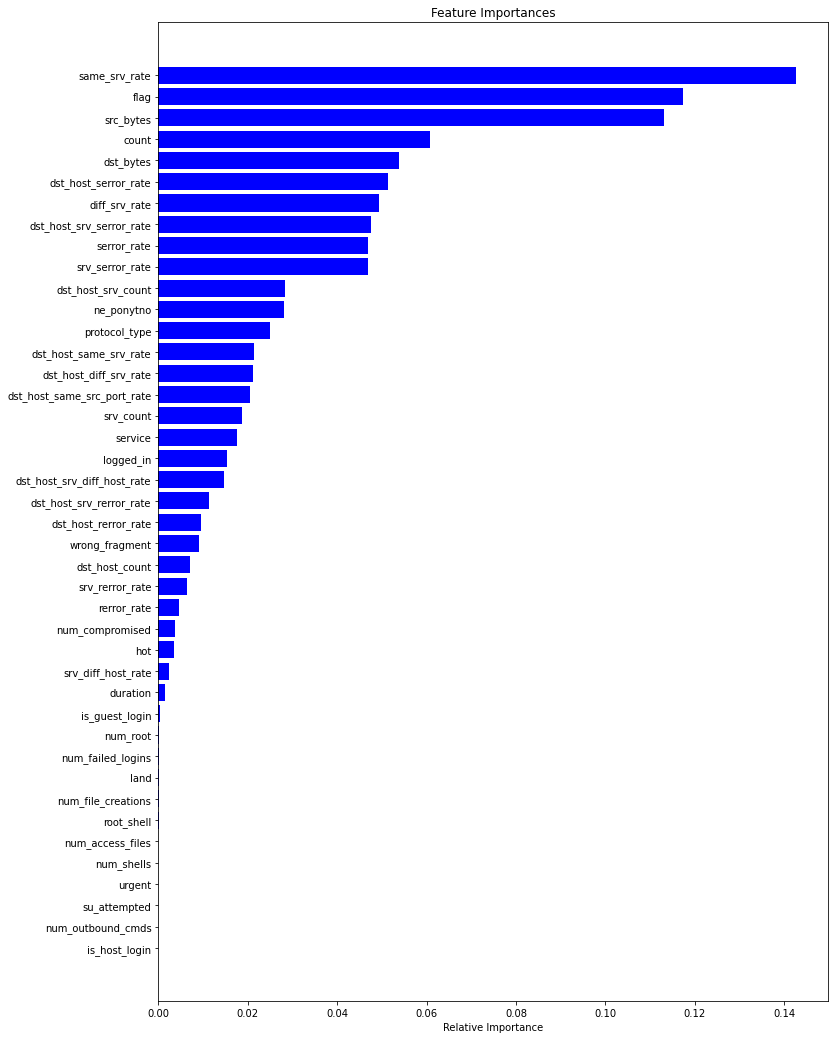

In [36]:
features = df.drop('target', axis=1).columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,18))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Общие фичи для 2х датасетов на основе [этой](http://www.takakura.com/Kyoto_data/BenchmarkData-Description-v5.pdf) статьи:

1. Duration: the length (number of seconds) of the connection
2. Service: the connection’s service type, e.g., http, telnet, etc
3. Source bytes: the number of data bytes sent by the source IP address
4. Destination bytes: the number of data bytes sent by the destination IP
address
5. Count: the number of connections whose source IP address and destina-
tion IP address are the same to those of the current connection in the
past two seconds
6. Same srv rate: % of connections to the same service in Count feature
7. Serror rate: % of connections that have “SYN” errors in Count feature
8. Srv serror rate: % of connections that have “SYN” errors in Srv count(the
number of connections whose service type is the same to that of the cur-
rent connection in the past two seconds) feature
9. Dst host count: among the past 100 connections whose destination IP
address is the same to that of the current connection, the number of connections whose source IP address is also the same to that of the current connection
10. Dst host srv count: among the past 100 connections whose destination IP address is the same to that of the current connection, the number of connections whose service type is also the same to that of the current connection
           
11. Dst host same src port rate: % of connections whose source port is the same to that of the current connection in Dst host count feature
12. Dst host serror rate: % of connections that have “SYN” errors in Dst host count feature
13. Dst host srv serror rate: % of connections that “SYN” errors in Dst host srv count feature
14. Flag: the state of the connection at the time the summary was written (which is usually when the connection terminated). The different states are summarized in the below section.

## Визуализация одного дерева решений из леса

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


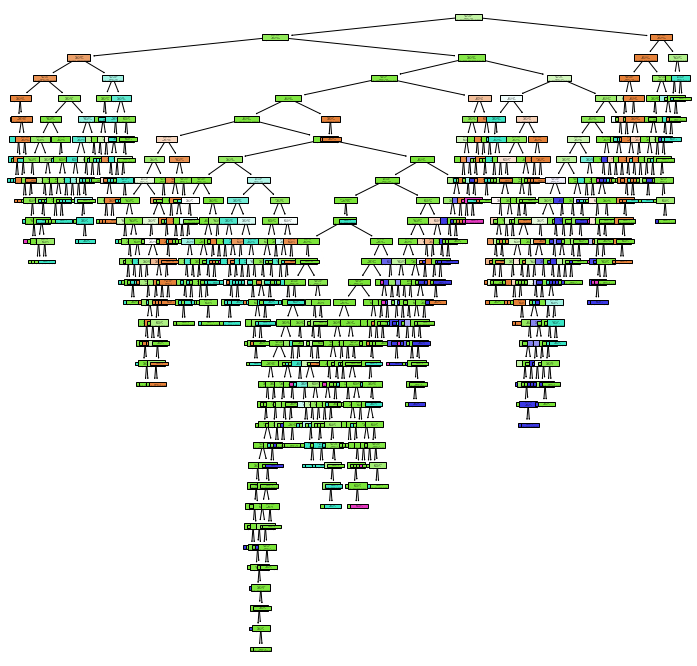

In [84]:
plt.figure(figsize=(12,12))
plot_tree(rfc.estimators_[0], filled=True)
plt.show()

# Задача бинарной классификации

In [24]:
# Преобразование столбцов с 24 классами в новые классы
y_tr = (fraud_classes_mapping(train.target) != 'norm').astype(int)
y_test = (fraud_classes_mapping(test.target) != 'norm').astype(int)
y_df = (fraud_classes_mapping(df.target) != 'norm').astype(int)

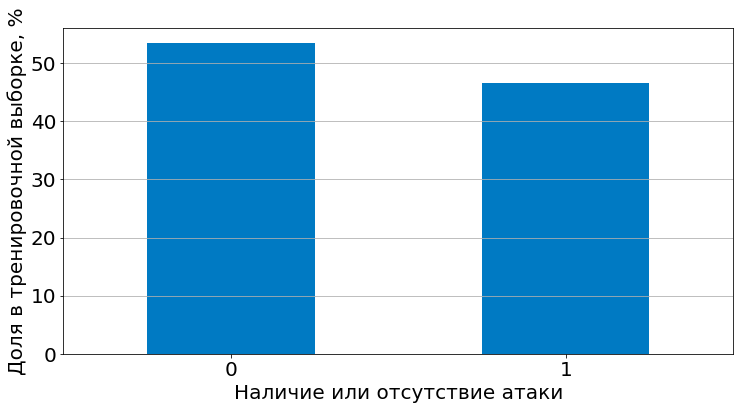

In [25]:
# Построим распределение классов в трейне
matplotlib.rcParams.update({'font.size': 20})
(y_tr.value_counts()/len(y_tr)*100).plot.bar(figsize=(12,6), color='#007AC3', rot=0)
plt.ylabel('Доля в тренировочной выборке, %')
plt.xlabel('Наличие или отсутствие атаки')
plt.grid(axis='y')
plt.show()

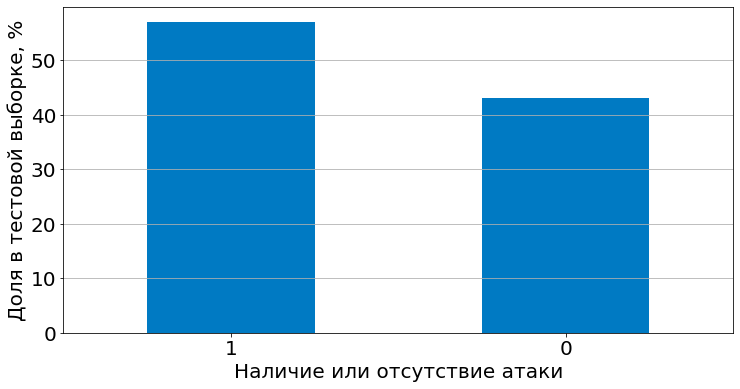

In [26]:
# Построим распределение классов в тесте
matplotlib.rcParams.update({'font.size': 20})
(y_test.value_counts()/len(y_test)*100).plot.bar(figsize=(12,6), color='#007AC3', rot=0)
plt.ylabel('Доля в тестовой выборке, %')
plt.xlabel('Наличие или отсутствие атаки')
plt.grid(axis='y')
plt.show()

## Обучение модели

In [27]:
X_train, X_val, y_train, y_val = train_test_split(df[:len(train)].drop(['target'], axis=1), y_tr, test_size=0.2, random_state=42, stratify=y_tr)

In [28]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=1, class_weight={0: 0.43, 1: 0.57})

In [29]:
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.43, 1: 0.57}, n_jobs=-1,
                       random_state=1)

Валидационная выборка:

In [30]:
print(f'Точность на валидационной выборке: {accuracy_score(rfc.predict(X_val),y_val):.5f}')

Точность на валидационной выборке: 0.99952


Тестовая выборка:

In [31]:
print(f"Точность на тестовой выборке: {accuracy_score(rfc.predict(df[len(train):].drop(['target'], axis=1)), y_test):.4f}")

Точность на тестовой выборке: 0.8123


In [32]:
start = datetime.datetime.now()
rfc.predict(df[len(train):].drop('target', axis=1))
end = datetime.datetime.now()
print(f'Время выполнения расчета для {len(y_test)} строк логов (тестовая выборка):\n{end-start}')

Время выполнения расчета для 22544 строк логов (тестовая выборка):
0:00:00.116877


In [33]:
%%timeit
rfc.predict(df[len(train):].drop('target', axis=1))

116 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


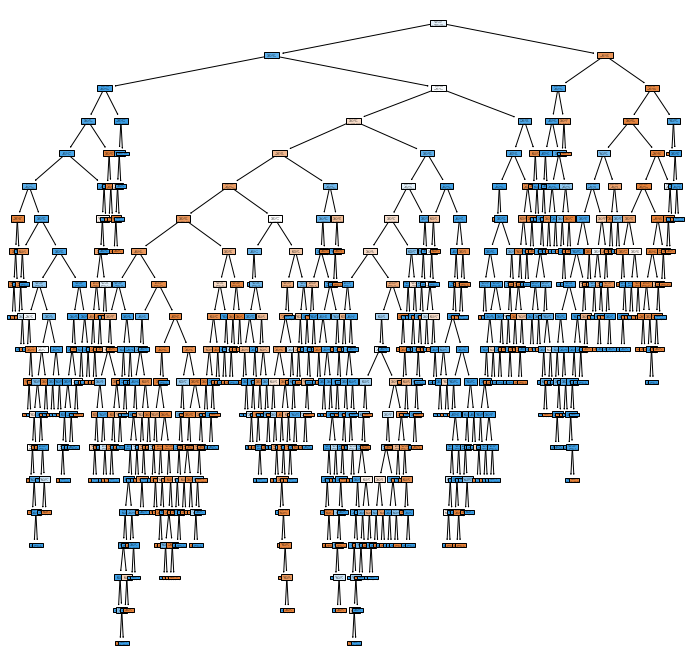

In [34]:
plt.figure(figsize=(12,12))
plot_tree(rfc.estimators_[0], filled=True)
plt.show()